In [1]:
from pathlib import Path
import sys  
import os
import pandas as pd 
from datetime import datetime
import scipy.sparse as sps
from numpy import linalg as LA
from tqdm import tqdm
import matplotlib.pyplot as plt

import numpy as np
from operator import itemgetter

In [2]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "libs")))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))

%load_ext autoreload
%autoreload 2

In [3]:
from Utils.load_URM import load_URM
from Utils.load_ICM import load_ICM

from scipy.sparse import hstack, vstack
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_all = load_URM("../data/data_train.csv")
ICM_all = load_ICM("../data/data_ICM_metadata.csv")

In [4]:
ICM_df = pd.read_csv("../data/data_ICM_metadata.csv")
ICM_df = ICM_df.rename(columns = {"item_id": "ItemID"})

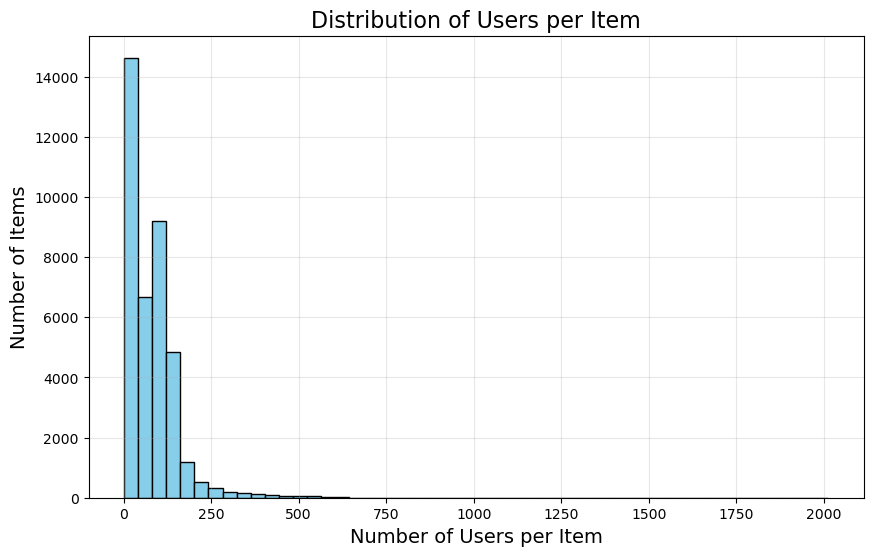

Top 10 items with the most users:
ItemID
15084    2013
22337    1199
8646     1084
4135     1019
6730      996
4953      986
23345     805
6694      791
13224     779
15318     775
16031     763
13322     755
15638     729
7535      729
12775     720
22377     705
23510     703
4634      691
4514      691
4150      680
dtype: int64


In [51]:
item_distribution = ICM_df.groupby("ItemID").size()

# Sort the distribution for better visualization (optional)
item_distribution_sorted = item_distribution.sort_values(ascending=False)

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(item_distribution, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Users per Item", fontsize=16)
plt.xlabel("Number of Users per Item", fontsize=14)
plt.ylabel("Number of Items", fontsize=14)
plt.grid(alpha=0.3)
plt.show()

# Optionally, inspect items with the most users
top_items = item_distribution_sorted.head(20)
print("Top 10 items with the most users:")
print(top_items)

In [82]:
SELECTED_FEATURES = item_distribution_sorted.head(100).keys().values

In [83]:
SELECTED_FEATURES

array([15084, 22337,  8646,  4135,  6730,  4953, 23345,  6694, 13224,
       15318, 16031, 13322, 15638,  7535, 12775, 22377, 23510,  4634,
        4514,  4150,  4133,  4380,  9452,  4004, 29932, 13321,  9530,
        4878,  4352,  4139, 18556,  4167,  4626,  1255, 13313,  7613,
       22336,  3717,  4217,  4642, 15319, 22401,  6403, 17478,  9570,
        8497, 17386,  9524, 23363,  4518,  3986,  4895, 22385,  8390,
        4324,  8403, 15692, 28744,  8173,  8140, 23987,   672, 18654,
       23217,  4198, 13439,   660, 20929,  4388,  8850,  8005,  8002,
       10331, 18088,  4712, 13977,  4692,  8341,  8461,  4673, 18066,
       23694, 20950, 17148, 28895,  3422, 18085, 19369,  7473, 22731,
       29941,  4990,  4474,  4661, 18091, 15775,  5804, 19290,  4872,
       19681])

In [5]:
from libs.Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender 
from libs.Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from libs.Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from libs.Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from libs.Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender

In [6]:
import optuna as op
from xgboost import XGBRanker
from xgboost import plot_importance

In [84]:
def create_dataframe_with_label(URM_features, URM_label, other_algorithms, cutoff, selected_features=
                                SELECTED_FEATURES):
    n_users_features, n_items_features = URM_features.shape
    training_dataframe = pd.DataFrame(index=range(0,n_users_features), columns = ["ItemID"])
    training_dataframe.index.name='UserID'
    #print(training_dataframe.columns)

    for user_id in range(n_users_features):    
        recommendations = other_algorithms["candidate_generator"].recommend(user_id, cutoff = cutoff)
        training_dataframe.loc[user_id, "ItemID"] = recommendations
        
    #print(training_dataframe.columns)
    training_dataframe = training_dataframe.explode("ItemID")

    URM_label_coo = sps.coo_matrix(URM_label)

    correct_recommendations = pd.DataFrame({"UserID": URM_label_coo.row,
                                        "ItemID": URM_label_coo.col})

    training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
    training_dataframe["Label"] = training_dataframe["Exist"] == "both"
    training_dataframe.drop(columns = ['Exist'], inplace=True)
    
    training_dataframe = training_dataframe.set_index('UserID')

    for user_id in range(n_users_features):  
        for rec_label, rec_instance in other_algorithms.items():
            if rec_label!= "candidate_generator":
                item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()
        
                all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

                training_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list] 

    training_dataframe = training_dataframe.reset_index()
    training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
    
    item_popularity = np.ediff1d(sps.csc_matrix(URM_features).indptr)

    training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]
    
    user_popularity = np.ediff1d(sps.csr_matrix(URM_features).indptr)

    training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]
    
    training_dataframe = training_dataframe.sort_values("UserID").reset_index()
    training_dataframe.drop(columns = ['index'], inplace=True)

     # Filter feature_data by selected_features
    filtered_features = ICM_df[ICM_df['feature_id'].isin(selected_features)]

    # Pivot the feature_data to create a sparse matrix-like structure
    feature_matrix = filtered_features.pivot(index='ItemID', columns='feature_id', values='data').fillna(0)

    # Merge feature data into training_dataframe
    training_dataframe = training_dataframe.merge(
        feature_matrix, on="ItemID", how="left"
    )
    training_dataframe = training_dataframe.fillna(0).infer_objects()
    
    return training_dataframe

In [85]:
def create_dataframe_without_label(URM_features, other_algorithms, cutoff, selected_features=
                                   SELECTED_FEATURES):
    n_users_features, n_items_features = URM_features.shape
    training_dataframe = pd.DataFrame(index=range(0,n_users_features), columns = ["ItemID"])
    training_dataframe.index.name='UserID'
    #print(training_dataframe.columns)
    #print(training_dataframe)
    
    for user_id in range(n_users_features):    
        recommendations = other_algorithms["candidate_generator"].recommend(user_id, cutoff = cutoff)
        training_dataframe.loc[user_id, "ItemID"] = recommendations
        
    #print(training_dataframe.columns)
    #print(training_dataframe)
    training_dataframe = training_dataframe.explode("ItemID")
    #training_dataframe = training_dataframe.set_index('UserID')

    for user_id in range(n_users_features):  
        for rec_label, rec_instance in other_algorithms.items():
            if rec_label!= "candidate_generator":
                item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()
        
                all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

                training_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list] 

    training_dataframe = training_dataframe.reset_index()
    training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
    
    item_popularity = np.ediff1d(sps.csc_matrix(URM_features).indptr)

    training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]
    ,
    user_popularity = np.ediff1d(sps.csr_matrix(URM_features).indptr)

    training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]
    
    training_dataframe = training_dataframe.sort_values("UserID").reset_index()
    training_dataframe.drop(columns = ['index'], inplace=True)

    filtered_features = ICM_df[ICM_df['feature_id'].isin(selected_features)]

    # Pivot the feature_data to create a sparse matrix-like structure
    feature_matrix = filtered_features.pivot(index='ItemID', columns='feature_id', values='data').fillna(0)

    # Merge feature data into training_dataframe
    training_dataframe = training_dataframe.merge(
        feature_matrix, on="ItemID", how="left"
    )
    training_dataframe = training_dataframe.fillna(0).infer_objects()
    
    return training_dataframe

In [57]:
def AP(recommended_items, relevant_items):
   
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    ap_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return ap_score

In [58]:
# We pass as paramether the recommender class

def evaluate_algorithm(URM_test, recommender_object, at=10):
    
    #cumulative_precision = 0.0
    #cumulative_recall = 0.0
    cumulative_AP = 0.0
    
    num_eval = 0


    for user_id in range(URM_test.shape[0]):

        relevant_items = URM_test.indices[URM_test.indptr[user_id]:URM_test.indptr[user_id+1]]
        
        if len(relevant_items)>0:
            
            recommended_items = recommender_object.recommend(user_id, cutoff=at)
            num_eval+=1

            #cumulative_precision += precision(recommended_items, relevant_items)
            #cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_AP += AP(recommended_items, relevant_items)
            
    #cumulative_precision /= num_eval
    #cumulative_recall /= num_eval
    MAP = cumulative_AP / num_eval
    
    return MAP

def evaluate_algorithm_xgboost(URM_test, dataframe_to_evaluate, model):
    
    cumulative_AP = 0.0
    
    num_eval = 0

    # we look for all the users 
    for user_id in tqdm(range(URM_test.shape[0])):
        
        # we get the relevant items for this user
        relevant_items = URM_test.indices[URM_test.indptr[user_id]:URM_test.indptr[user_id+1]]
        
        # if the user have something in the test data we evaluate it
        if len(relevant_items)>0:
            
            X_to_predict = dataframe_to_evaluate[dataframe_to_evaluate["UserID"] == user_id].copy()

            preds = model.predict(X_to_predict)
            X_to_predict["rank"] = preds
            X_to_predict = X_to_predict.sort_values(by = "rank", ascending = False)
            recommended_items = np.array(X_to_predict["ItemID"])[:10]
            
            num_eval+=1

            cumulative_AP += AP(recommended_items, relevant_items)
            
    MAP = cumulative_AP / num_eval
    
    return MAP

In [59]:
URM_train = sps.load_npz("URM_train_ens.npz")
URM_val = sps.load_npz("URM_val_ens.npz")
URM_test = sps.load_npz("URM_test_ens.npz")

URM_train_val = sps.load_npz("URM_train_val_ens.npz")

In [60]:
evaluator_val = EvaluatorHoldout(URM_val, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 1008 ( 2.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 527 ( 1.5%) Users that have less than 1 test interactions


# Models

In [61]:
SLIM_ElasticRecall_eval = SLIMElasticNetRecommender(URM_train)
SLIM_ElasticRecall_eval.load_model("result_experiments/SLIM/", "SLIM_ElasticRecall_eval")

RP3BetaRecall_eval = RP3betaRecommender(URM_train)
RP3BetaRecall_eval.load_model("result_experiments/RP3beta/", "RP3BetaRecall_eval")

KNNRecall_eval = ItemKNNCFRecommender(URM_train)
KNNRecall_eval.load_model("result_experiments/ItemKNNCFRecommender/", "KNNRecall_eval")

new_similarityRecall_eval = 0.7747783599151299 * SLIM_ElasticRecall_eval.W_sparse + 0.10970438576060675 * RP3BetaRecall_eval.W_sparse + 0.1155172543242634 * KNNRecall_eval.W_sparse
candidate_gen_eval = ItemKNNCustomSimilarityRecommender(URM_train)
candidate_gen_eval.fit(new_similarityRecall_eval)

SLIMElasticNetRecommender: Loading model from file 'result_experiments/SLIM/SLIM_ElasticRecall_eval'
SLIMElasticNetRecommender: Loading complete
RP3betaRecommender: Loading model from file 'result_experiments/RP3beta/RP3BetaRecall_eval'
RP3betaRecommender: Loading complete
ItemKNNCFRecommender: Loading model from file 'result_experiments/ItemKNNCFRecommender/KNNRecall_eval'
ItemKNNCFRecommender: Loading complete


In [62]:
SLIM_Elastic_eval = SLIMElasticNetRecommender(URM_train)
SLIM_Elastic_eval.load_model("result_experiments/SLIM/", "SLIM_Elastic_eval")

RP3Beta_eval = RP3betaRecommender(URM_train)
RP3Beta_eval.load_model("result_experiments/RP3beta/", "RP3Beta_eval")

KNN_eval = ItemKNNCFRecommender(URM_train)
KNN_eval.load_model("result_experiments/ItemKNNCFRecommender/", "KNN_eval")

best_similarity_eval = 0.862708291473966 * SLIM_Elastic_eval.W_sparse + 0.10238146945917358 * RP3Beta_eval.W_sparse + 0.034910239066860506 * KNN_eval.W_sparse
best_hybrid_eval = ItemKNNCustomSimilarityRecommender(URM_train)
best_hybrid_eval.fit(best_similarity_eval)

SLIMElasticNetRecommender: Loading model from file 'result_experiments/SLIM/SLIM_Elastic_eval'
SLIMElasticNetRecommender: Loading complete
RP3betaRecommender: Loading model from file 'result_experiments/RP3beta/RP3Beta_eval'
RP3betaRecommender: Loading complete
ItemKNNCFRecommender: Loading model from file 'result_experiments/ItemKNNCFRecommender/KNN_eval'
ItemKNNCFRecommender: Loading complete


In [47]:
pr3alpha = pd.read_csv("result_experiments/RP3alpha/results_optuna.csv")

In [49]:
pr3alpha.sort_values("result", ascending=False)

,Unnamed: 0,topK,alpha,result
101,101,13.0,0.358969,0.054205
264,264,13.0,0.356510,0.054203
280,280,13.0,0.359350,0.054201
97,97,13.0,0.356190,0.054192
267,267,13.0,0.355121,0.054187
...,...,...,...,...
154,154,2.0,0.350523,0.036901
213,213,2.0,0.350160,0.036896
220,220,2.0,0.350028,0.036895
248,248,2.0,0.350073,0.036895


In [63]:
P3Alpha_eval = P3alphaRecommender(URM_train)
P3Alpha_eval.fit(topK=19, alpha=0.4176290154380183)

P3alphaRecommender: Similarity column 38121 (100.0%), 5195.66 column/sec. Elapsed time 7.34 sec


In [64]:
print(f"Hybrid: {evaluate_algorithm(URM_val, best_hybrid_eval)}\n",
      f"SLIM: {evaluate_algorithm(URM_val, SLIM_Elastic_eval)}\n",
      f"P3Beta: {evaluate_algorithm(URM_val, RP3Beta_eval)}\n",
      f"KNN: {evaluate_algorithm(URM_val, KNN_eval)}\n",
      f"P3Alpha: {evaluate_algorithm(URM_val, P3Alpha_eval)}\n")

Hybrid: 0.06335824141991994
 SLIM: 0.06301192406753578
 P3Beta: 0.058588907885092474
 KNN: 0.058090943997984236
 P3Alpha: 0.04813364063476029



In [65]:
other_algorithms_eval = {
    "RP3beta": RP3Beta_eval,
    "SLIM": SLIM_Elastic_eval,
    "KNN": KNN_eval,
    "best_hybrid": best_hybrid_eval,
    # "SLIM_bpr":SLIM_bpr,
    # "P3a":P3a,
    "candidate_generator": candidate_gen_eval
}

In [66]:
# cutoff = 66
# n_estimators = 849
# learning_rate = 0.3637770992742871
# reg_alpha = 50.44532162296401
# reg_lambda = 0.3859479066775696
# max_depth = 8
# max_leaves = 5

# cutoff = 37
# n_estimators = 1123
# learning_rate = 0.09311468937718011
# reg_alpha = 31.624312041357612
# reg_lambda = 0.3483672285949974
# max_depth = 5
# max_leaves = 5

cutoff = 33
n_estimators = 734
learning_rate = 0.3220652624797847
reg_alpha = 33.0894798497184
reg_lambda = 0.5041606291417153
max_depth = 4
max_leaves = 7
min_child_weight = 5
colsample_bytree = 0.6215918361638323
subsample = 0.9970033845065275
gamma = 4.2690557138141605
max_bin= 430

In [67]:
# training_dataframe = create_dataframe_with_label(URM_train, URM_val, other_algorithms_eval, cutoff=cutoff)

In [68]:
SLIM_ElasticRecall_train_val_eval = SLIMElasticNetRecommender(URM_train+URM_val)
SLIM_ElasticRecall_train_val_eval.load_model("result_experiments/SLIM/", "SLIM_ElasticRecall_train_val_eval")

RP3BetaRecall_train_val_eval = RP3betaRecommender(URM_train+URM_val)
RP3BetaRecall_train_val_eval.load_model("result_experiments/RP3beta/", "RP3BetaRecall_train_val_eval")

KNNRecall_train_val_eval = ItemKNNCFRecommender(URM_train+URM_val)
KNNRecall_train_val_eval.load_model("result_experiments/ItemKNNCFRecommender/", "KNNRecall_train_val_eval")

SLIMElasticNetRecommender: Loading model from file 'result_experiments/SLIM/SLIM_ElasticRecall_train_val_eval'
SLIMElasticNetRecommender: Loading complete
RP3betaRecommender: Loading model from file 'result_experiments/RP3beta/RP3BetaRecall_train_val_eval'
RP3betaRecommender: Loading complete
ItemKNNCFRecommender: Loading model from file 'result_experiments/ItemKNNCFRecommender/KNNRecall_train_val_eval'
ItemKNNCFRecommender: Loading complete


In [69]:
new_similarityRecall_train_val_eval = 0.7747783599151299 * SLIM_ElasticRecall_train_val_eval.W_sparse + 0.10970438576060675 * RP3BetaRecall_train_val_eval.W_sparse + 0.1155172543242634 * KNNRecall_train_val_eval.W_sparse
candidate_gen_train_val_eval = ItemKNNCustomSimilarityRecommender(URM_train+URM_val)
candidate_gen_train_val_eval.fit(new_similarityRecall_train_val_eval)

In [70]:
SLIM_Elastic_train_val_eval = SLIMElasticNetRecommender(URM_train+URM_val)
SLIM_Elastic_train_val_eval.load_model("result_experiments/SLIM/", "SLIM_Elastic_train_val_eval")

RP3Beta_train_val_eval = RP3betaRecommender(URM_train+URM_val)
RP3Beta_train_val_eval.load_model("result_experiments/RP3beta/", "RP3Beta_train_val_eval")

KNN_train_val_eval = ItemKNNCFRecommender(URM_train+URM_val)
KNN_train_val_eval.load_model("result_experiments/ItemKNNCFRecommender/", "KNN_train_val_eval")

SLIMElasticNetRecommender: Loading model from file 'result_experiments/SLIM/SLIM_Elastic_train_val_eval'
SLIMElasticNetRecommender: Loading complete
RP3betaRecommender: Loading model from file 'result_experiments/RP3beta/RP3Beta_train_val_eval'
RP3betaRecommender: Loading complete
ItemKNNCFRecommender: Loading model from file 'result_experiments/ItemKNNCFRecommender/KNN_train_val_eval'
ItemKNNCFRecommender: Loading complete


In [71]:
best_similarity_train_val_eval = 0.862708291473966 * SLIM_Elastic_train_val_eval.W_sparse + 0.10238146945917358 * RP3Beta_train_val_eval.W_sparse + 0.034910239066860506 * KNN_train_val_eval.W_sparse
best_hybrid_train_val_eval = ItemKNNCustomSimilarityRecommender(URM_train+URM_val)
best_hybrid_train_val_eval.fit(best_similarity_train_val_eval)

In [72]:
other_algorithms_train_val_eval = {
    "RP3beta": RP3Beta_train_val_eval,
    "SLIM": SLIM_Elastic_train_val_eval,
    "KNN": KNN_train_val_eval,
    "best_hybrid": best_hybrid_train_val_eval,
    # "SLIM_bpr":SLIM_bpr,
    # "P3a":P3a,
    "candidate_generator": candidate_gen_train_val_eval
}

In [73]:
print(f"Hybrid: {evaluate_algorithm(URM_test, best_hybrid_train_val_eval)}\n",
      f"SLIM: {evaluate_algorithm(URM_test, SLIM_Elastic_train_val_eval)}\n",
      f"RP3Beta: {evaluate_algorithm(URM_test, RP3Beta_train_val_eval)}\n", 
      f"KNN: {evaluate_algorithm(URM_test, KNN_train_val_eval)}")

Hybrid: 0.08402817565563181
 SLIM: 0.0837216876601205
 RP3Beta: 0.07551240567510359
 KNN: 0.0747781539320609


In [76]:
xgb_res = pd.read_csv("result_experiments/XGBOST/optuna_res4.csv")

In [78]:
xgb_res.sort_values("MAP", ascending=False)

,cutoff,n_estimators,learning_rate,reg_alpha,reg_lambda,max_depth,max_leaves,min_child_weight,colsample_bytree,subsample,gamma,max_bin,iteration,MAP
7,29,712,0.471764,37.408431,0.459032,6,13,10,0.797564,0.842786,5.268683,570,7,0.084065
75,38,599,0.363104,44.500229,0.373627,10,10,10,0.726528,0.827797,5.147433,323,75,0.084013
99,18,551,0.396213,46.779639,0.363174,10,13,3,0.740828,0.783486,4.520521,341,99,0.084007
82,36,627,0.346421,46.487899,0.357045,9,11,10,0.708235,0.810657,5.026003,360,82,0.084000
26,28,602,0.385257,39.721696,0.597151,6,7,10,0.754728,0.804258,2.838666,142,26,0.083990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,51,665,0.341552,47.284286,0.404657,10,11,2,0.374536,0.813502,2.794544,347,69,0.083419
14,29,770,0.422390,37.224514,0.525600,5,13,8,0.544630,0.849217,0.247275,401,14,0.083402
2,63,584,0.375131,38.552127,0.700664,5,5,2,0.742627,0.767345,3.757473,72,2,0.083137
39,89,612,0.415484,36.192434,0.346098,10,7,9,0.697229,0.928261,2.946054,101,39,0.083089


In [88]:
def objective(optuna_trial):
    cutoff = optuna_trial.suggest_int("cutoff", 20, 40)
    n_estimators = optuna_trial.suggest_int("n_estimators", 500, 800)
    learning_rate =optuna_trial.suggest_float("learning_rate", 0.3, 0.55)
    reg_alpha = optuna_trial.suggest_float("reg_alpha", 34, 50)
    reg_lambda = optuna_trial.suggest_float("reg_lambda", 0.3, 0.6)
    max_depth = optuna_trial.suggest_int("max_depth", 4, 11)
    max_leaves = optuna_trial.suggest_int("max_leaves", 5, 13)

    min_child_weight = optuna_trial.suggest_int("min_child_weight", 5, 10)
    colsample_bytree = optuna_trial.suggest_float("colsample_bytree", 0.4, 0.9)
    subsample = optuna_trial.suggest_float("subsample", 0.6, 0.95)
    gamma = optuna_trial.suggest_float("gamma", 4.0, 8.0)
    max_bin = optuna_trial.suggest_int("max_bin", 256, 700)
    
    grow_policy = "depthwise"
    objective = "pairwise"
    booster = "gbtree"
    random_seed = None

    training_dataframe=training_dataframe = create_dataframe_with_label(URM_train, URM_val, other_algorithms_eval, cutoff=cutoff)
    test_dataframe=create_dataframe_without_label(URM_train+URM_val, other_algorithms_train_val_eval, cutoff=cutoff)
    groups = training_dataframe.groupby("UserID").size().values
    
    y_train= training_dataframe["Label"]
    X_train = training_dataframe.drop(columns=["Label"])
    X_train["UserID"] = X_train["UserID"].astype("category")
    X_train["ItemID"] = X_train["ItemID"].astype("category")
    
    test_dataframe["UserID"] = test_dataframe["UserID"].astype("category")
    test_dataframe["ItemID"] = test_dataframe["ItemID"].astype("category")
    
    XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = int(max_depth),
                      max_leaves = int(max_leaves),
                      grow_policy = grow_policy,
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = booster,
                      enable_categorical = True,
                      tree_method = "hist",  # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
                      
                      min_child_weight=min_child_weight,
                      colsample_bytree=colsample_bytree,
                      subsample=subsample,
                      gamma=gamma,
                      max_bin=max_bin
        )

    XGB_model.fit(X_train,
                y_train,
                group=groups,
                verbose=True)
    
       
    return evaluate_algorithm_xgboost(URM_test, test_dataframe, XGB_model)

In [89]:
class SaveResults(object):
    def __init__(self, file_path=None):
        self.file_path = file_path
        self.results = []
    
    def __call__(self, optuna_study, optuna_trial):
        trial_result = optuna_trial.params.copy()
        trial_result["iteration"] = optuna_trial.number
        trial_result["MAP"] = optuna_trial.value
        
        self.results.append(trial_result)
        
        # Convert to DataFrame and save to CSV
        results_df = pd.DataFrame(self.results)
        results_df.to_csv(self.file_path, index=False)

In [ ]:
study = op.create_study(direction="maximize")
save_results= SaveResults("result_experiments/XGBOST/optuna_res5.csv")
study.optimize(objective, callbacks=[save_results], n_trials=100)

[I 2025-01-05 11:52:12,726] A new study created in memory with name: no-name-87769500-643b-4e75-9869-cbe58a0c6fe3
/var/folders/tr/d1rx7zt15lzgkp2yc1nwbg100000gn/T/ipykernel_59053/726086598.py:59: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  training_dataframe = training_dataframe.fillna(0).infer_objects()
/var/folders/tr/d1rx7zt15lzgkp2yc1nwbg100000gn/T/ipykernel_59053/3167379555.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  training_dataframe = training_dataframe.fillna(0).infer_objects()
100%|████████████████████████████████████| 35736/35736 [0

In [ ]:
study.best_params, study.best_trial

In [25]:
xgb_res = pd.read_csv('result_experiments/XGBOST/optuna_res3.csv')

In [26]:
xgb_res.sort_values("MAP", ascending=False)

,cutoff,n_estimators,learning_rate,reg_alpha,reg_lambda,max_depth,max_leaves,min_child_weight,colsample_bytree,subsample,gamma,max_bin,iteration,MAP
39,33,734,0.322065,33.089480,0.504161,4,7,5,0.621592,0.997003,4.269056,430,39,0.084017
98,21,659,0.265125,34.627080,0.517533,6,8,3,0.782683,0.791438,2.852241,464,98,0.084015
55,26,687,0.231164,50.992598,0.435819,5,7,5,0.781522,0.904968,2.869554,471,55,0.084010
20,20,637,0.390250,31.922447,0.545390,6,7,4,0.577222,0.925465,4.711378,299,20,0.083998
92,33,609,0.235270,33.663209,0.552092,7,5,4,0.583015,0.809121,3.845704,421,92,0.083995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,127,503,0.308817,31.077576,0.489301,6,8,5,0.603813,0.739343,8.474957,251,36,0.083387
89,45,951,0.354703,32.706398,0.509280,8,7,2,0.535880,0.690757,9.485124,353,89,0.083372
56,198,679,0.187080,50.435027,0.438680,6,9,6,0.768844,0.907191,2.757683,508,56,0.083337
18,131,857,0.209965,36.715043,0.642258,8,9,6,0.819825,0.699841,0.327066,248,18,0.083242


# Try to find best item features

In [86]:
checking_dataframe = create_dataframe_with_label(URM_train, URM_val, other_algorithms_eval, cutoff=33)

/var/folders/tr/d1rx7zt15lzgkp2yc1nwbg100000gn/T/ipykernel_59053/726086598.py:59: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  training_dataframe = training_dataframe.fillna(0).infer_objects()


In [87]:
checking_dataframe

,UserID,ItemID,Label,RP3beta,SLIM,KNN,best_hybrid,item_popularity,user_profile_len,660,...,23217,23345,23363,23510,23694,23987,28744,28895,29932,29941
0,0,14888,False,0.239205,0.270506,0.236315,0.266108,85,79,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,18682,False,0.110481,0.100159,0.235508,0.105940,27,79,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,11685,False,0.121552,0.143381,0.000000,0.136141,48,79,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,12714,False,0.129657,0.130997,0.087034,0.129325,18,79,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,21974,False,0.151293,0.116940,0.141232,0.121305,31,79,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179283,35735,37441,False,0.169870,0.193489,0.230943,0.192379,24,24,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1179284,35735,34998,False,0.071028,0.216814,0.161043,0.199942,44,24,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1179285,35735,37019,True,0.175950,0.184486,0.338253,0.188980,40,24,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1179286,35735,37448,False,0.242345,0.248263,0.384860,0.252426,24,24,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
feature_data = pd.read_csv("../data/data_ICM_metadata.csv")

In [78]:
filtered_features = filtered_features.rename(columns={"item_id": "ItemID"})

In [79]:
feature_matrix = filtered_features.pivot(index='ItemID', columns='feature_id', values='data').fillna(0)

    # Merge feature data into training_dataframe
checking_dataframe_merged = checking_dataframe.merge(
    feature_matrix, on="ItemID", how="left"
)

In [82]:
checking_dataframe_merged = checking_dataframe_merged.fillna(0)

/var/folders/tr/d1rx7zt15lzgkp2yc1nwbg100000gn/T/ipykernel_57246/467352485.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  checking_dataframe_merged = checking_dataframe_merged.fillna(0)


1188.0

In [68]:
selected_features = [15084, 22337]
filtered_features = feature_data[feature_data['feature_id'].isin(selected_features)]


In [60]:
icm_df

,item_id,feature_id,data
0,2519,0,1.0
1,2642,0,1.0
2,3316,0,1.0
3,3400,0,1.0
4,3472,0,1.0
...,...,...,...
2940035,38107,94326,1.0
2940036,38107,94327,1.0
2940037,38107,94328,1.0
2940038,38112,94329,1.0


## Old attempts:

In [41]:
test_dataframe=create_dataframe_without_label(URM_train+URM_val, other_algorithms_train_val_eval, cutoff=cutoff)

In [42]:
y_train= training_dataframe["Label"]
X_train = training_dataframe.drop(columns=["Label"])
X_train["UserID"] = X_train["UserID"].astype("category")
X_train["ItemID"] = X_train["ItemID"].astype("category")

test_dataframe["UserID"] = test_dataframe["UserID"].astype("category")
test_dataframe["ItemID"] = test_dataframe["ItemID"].astype("category")

In [43]:
groups = training_dataframe.groupby("UserID").size().values

In [44]:
grow_policy = "depthwise"
objective = "pairwise"
booster = "gbtree"
random_seed = None

XGB_model_test_best = XGBRanker(objective='rank:{}'.format(objective),
                  n_estimators = int(n_estimators),
                  random_state = random_seed,
                  learning_rate = learning_rate,
                  reg_alpha = reg_alpha,
                  reg_lambda = reg_lambda,
                  max_depth = int(max_depth),
                  max_leaves = int(max_leaves),
                  grow_policy = grow_policy,
                  verbosity = 0, # 2 if self.verbose else 0,
                  booster = booster,
                  enable_categorical = True,
                  tree_method = "hist",  # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
                  )

XGB_model_test_best.fit(X_train,
            y_train,
            group=groups,
            verbose=True)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device=None, early_stopping_rounds=None, enable_categorical=True,
          eval_metric=None, feature_types=None, gamma=None,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.09311468937718011,
          max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
          max_delta_step=None, max_depth=5, max_leaves=5, min_child_weight=None,
          missing=nan, monotone_constraints=None, multi_strategy=None,
          n_estimators=1123, n_jobs=None, num_parallel_tree=None,
          objective='rank:pairwise', ...)

In [45]:
print(evaluate_algorithm_xgboost(URM_test, test_dataframe, XGB_model_test_best))

100%|████████████████████████████████████| 35736/35736 [01:01<00:00, 576.87it/s]

0.08369135410951216


<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

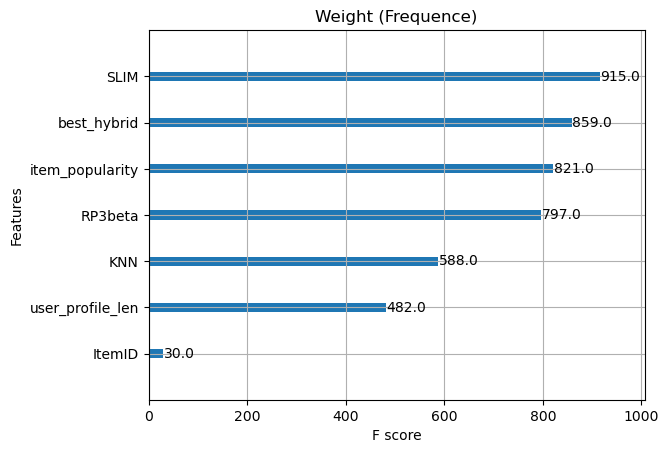

In [46]:
plot_importance(XGB_model_test_best, importance_type='weight', title='Weight (Frequence)')